# Shared and population-specific genetic variation

This analysis aimed to answer the following research question: **To what extent is genetic variation shared or unique within Central, Southern, Eastern and Western African populations?**

The following steps were completed:

1. Data Generation: Genetic variation data was generated from genetic information obtained from the [GnomAD 1000 Genomes and HGDP datasets](https://gnomad.broadinstitute.org/news/2021-10-gnomad-v3-1-2-minor-release/) for African population groups.
2. Data Preparation: The generated genetic variation data was processed and prepared for analysis following the steps detailed in the `Notebooks\Data_preparation\2-IH_allele_counts.ipynb` Jupyter notebook. The resulting prepared data included variant positional information, allele counts, and frequencies, which are stored in the `Data\Processed\IH_allele_counts.csv` file. Additionally, metadata on the individuals from which genetic variation data was generated, was prepared and stored in the `Sample_populations.csv` file. 
3. Analysis and Visualisation: 
    * An initial exploration of the data was involved constructing a variant discovery curve, to gain an understanding of how much unique genetic variation is contributed by each African ethnolinguistic population group to the analysis.
    * Genetic variant data was grouped based on geographic region (Central, Southern, Eastern and Western Africa). Through this categorisation, the variants unique to each region and shared between regions were determined. To compare the shared and unique genetic variation among the different African regions, upset plots were used. Upset plots are data visualizations that allow for easy comparison of overlapping or intersecting sets or categories, providing a clear picture of the genetic variation patterns among the African populations.

## Imports

Notebook setup

In [21]:
import os
import sys

from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import pandas as pd
import upsetplot
from matplotlib import pyplot as plt
import seaborn as sns
import Utils.constants as constants
import Utils.functions as functions

Import variant count data

In [22]:
ih_allele_counts = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
).drop(columns=["Unnamed: 0"])

ih_allele_counts.head(5)

,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,ID,CORR_IH_TOTAL_CTS,CORR_IH_REF_CTS,CORR_IH_AF,REG,VARIANT_TYPE
0,chr13:110148882C-CT,110148882,C,CT,COL4A1,African Caribbean,0,228,110148882_CT_C,228,228,0.0,ACB,INDEL
1,chr13:110148882C-CT,110148882,C,CT,COL4A1,HGDP Yoruba,0,42,110148882_CT_C,42,42,0.0,WA,INDEL
2,chr13:110148882C-CT,110148882,C,CT,COL4A1,Mandenka,0,46,110148882_CT_C,46,46,0.0,WA,INDEL
3,chr13:110148882C-CT,110148882,C,CT,COL4A1,Esan,0,296,110148882_CT_C,296,296,0.0,WA,INDEL
4,chr13:110148882C-CT,110148882,C,CT,COL4A1,Bantu Kenya,0,24,110148882_CT_C,24,24,0.0,EA,INDEL


Import sample population data 

In [23]:
sample_subpopulations = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "Sample_populations.csv",
    )
).drop(columns="Unnamed: 0")

sample_subpopulations.tail(5)

,SUB,SAMPLE_NAME,REG
984,African American,NA20412,ASW
985,Mandenka,SS6004470,WA
986,Mbuti Pygmy,SS6004471,CA
987,San,SS6004473,SA
988,HGDP Yoruba,SS6004475,WA


## Data analysis and visualisation

### Variant count as a function of the number of samples contributed by a population group


To get an understanding of how much unique genetic variation is contributed by each African population group to the analysis, I visualised the number of unique variants as a function of the number of samples contributed by a population group. In this visualisation, I incrementally added each subpopulation group to the analysis, allowing the observation of how much unique genetic variation each population group brings to the overall dataset. This approach helps in understanding the diversity and genetic distinctiveness of each African population group and their collective impact on the analysis.

Group sample data by subpopulation

In [24]:
grouped_sample_subpopulations = (
    functions.group_and_count(sample_subpopulations, ["SUB"])
    .reset_index()
    .rename(columns={"SAMPLE_NAME": "SAMPLE_COUNT"})
    .drop(columns="REG")
)
grouped_sample_subpopulations["REG"] = grouped_sample_subpopulations["SUB"].map(
    constants.REGIONAL_CLASSIFICATION
)

Remove data for African American or African Caribbean populations

In [25]:
# Use ih_allele_counts dataframe. Remove rows with variants with alternate allele frequencies of 0. These variants are not present in the subpopulation.
region_specific_allele_counts = ih_allele_counts.dropna(subset="SUB_POP")[
    ~(ih_allele_counts.CORR_IH_AF == 0.0)
]

# Drop ASW and ACB regions
region_specific_allele_counts = region_specific_allele_counts[
    ~(
        (region_specific_allele_counts.REG == "ACB")
        | (region_specific_allele_counts.REG == "ASW")
    )
]

C:\Users\User\AppData\Local\Temp\ipykernel_21472\197205327.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  region_specific_allele_counts = ih_allele_counts.dropna(subset="SUB_POP")[


Order Eastern, Western, Southern and Central African subpopulations in order of smallest to largest population count.

In [26]:
# Order subpopulations by sample count. Re-use grouped_sample_subpopulations dataframe.
subpopulation_order = grouped_sample_subpopulations.sort_values(
    by=["SAMPLE_COUNT", "REG"]
).SUB.tolist()

# Order subpopulations in region_specific_allele_counts dataframe.
collated_af_ordered = region_specific_allele_counts.copy()
collated_af_ordered.sort_values(
    by="SUB_POP",
    key=lambda column: column.map(lambda e: subpopulation_order.index(e)),
    inplace=True,
)

Remove duplicated variants to avoid counting the same variant twice. We would like to see how the number of unique variants changes with the addition of sample populations, so need to avoid counting the same variant twice.

In [27]:
collated_af_unique = collated_af_ordered.drop_duplicates(subset=["ID"])

Group by sub-population and count the cumulative number of variants

In [28]:
collated_af_subpop = (
    collated_af_unique.groupby(["SUB_POP"])
    .size()
    .reset_index()
    .rename(columns={0: "VARIANT_COUNT"})
)
collated_af_subpop.sort_values(
    by="SUB_POP",
    key=lambda column: column.map(lambda e: subpopulation_order.index(e)),
    inplace=True,
)
collated_af_subpop["CUMULATIVE_TOTAL_VARIANTS"] = collated_af_subpop[
    "VARIANT_COUNT"
].cumsum()

Add sample count information to dataframe and count cumulative number of samples

In [29]:
collated_af_subpop = (
    collated_af_subpop.merge(
        grouped_sample_subpopulations, left_on="SUB_POP", right_on="SUB"
    )
    .drop(columns=["SUB"])
    .set_index("SUB_POP")
)
collated_af_subpop["CUMULATIVE_SAMPLES"] = collated_af_subpop.sort_values(
    by=["VARIANT_COUNT", "REG"], ascending=True
)["SAMPLE_COUNT"].cumsum()
collated_af_subpop.head(5)

,VARIANT_COUNT,CUMULATIVE_TOTAL_VARIANTS,SAMPLE_COUNT,REG,CUMULATIVE_SAMPLES
SUB_POP,,,,,
San,2267,2267,6,SA,804
Bantu South Africa,949,3216,8,SA,701
Bantu Kenya,654,3870,12,EA,419
Mbuti Pygmy,613,4483,14,CA,407
HGDP Yoruba,591,5074,21,WA,393


Set plot parameters

In [30]:
sns.set(rc={"figure.figsize": (10, 8)})  # set plot size

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

Create a plot showing the number of genetic variants as a function of sample size, while incrementally adding each subpopulation group to the analysis in a cumulative manner.

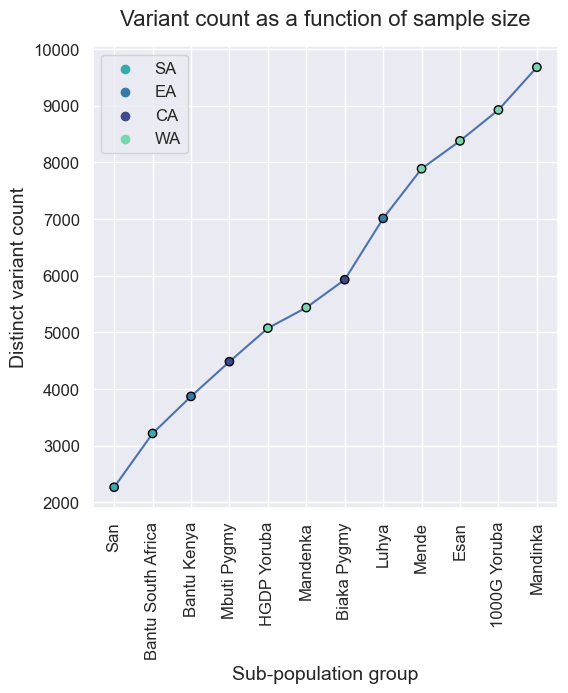

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))  # Set a custom size for this figure

# Assign the plot colouring

color_dict = dict({"SA": "#38AAAC", "EA": "#357BA3", "CA": "#40498E", "WA": "#79D6AE"})

# Create scatter plot

cum_variant_lineplot = sns.scatterplot(
    data=collated_af_subpop,
    x="SUB_POP",
    y="CUMULATIVE_TOTAL_VARIANTS",
    marker="o",
    hue="REG",
    palette=color_dict,
    edgecolor="black",
    linewidth=1,
    zorder=100,
)

# Create a line plot

cum_variant_lineplot = sns.lineplot(
    data=collated_af_subpop,
    x="SUB_POP",
    y="CUMULATIVE_TOTAL_VARIANTS",
    marker=None,
    zorder=1,
)

# Set x and y labels, title, and xtick rotation

cum_variant_lineplot.set(xlabel="Sub-population group", ylabel="Distinct variant count")
plt.xticks(rotation=90)
plt.title(
    "Variant count as a function of sample size",
    size=constants.LARGEST_FONT,
    pad=15,
    loc="center",
)

plt.savefig(
    "..\Results\Figures\Variant_discovery_curve.png", dpi=1200, bbox_inches="tight"
)
plt.show()

In the above figure, we can observe that the number of variants included in the analysis increases with each incremental addition of population group samples.

### Compare shared and unique genetic variation among the different African regions

Group data by variant and region

In [32]:
region_specific_allele_counts = ih_allele_counts.groupby(
    by=["VAR_NAME", "ID", "POS", "REF", "ALT", "VARIANT_TYPE", "GENE", "REG"]
).sum()

region_specific_allele_counts = (
    region_specific_allele_counts[~(region_specific_allele_counts.IH_ALT_CTS == 0)] # Remove rows with variants with alternate allele counts of 0. These variants are not present in the region.
    .drop(columns="CORR_IH_AF")
    .reset_index()
)

C:\Users\User\AppData\Local\Temp\ipykernel_21472\2254517746.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region_specific_allele_counts = ih_allele_counts.groupby(


Drop rows with region set to African, Recent African, African American or African Caribbean

In [33]:
region_specific_allele_counts = region_specific_allele_counts[
    ~(
        (region_specific_allele_counts.REG == "Recent African")
        | (region_specific_allele_counts.REG == "African")
        | (region_specific_allele_counts.REG == "ACB")
        | (region_specific_allele_counts.REG == "ASW")
    )
]

Generate a dictionary with lists of variants for each region

In [34]:
region_variant_dict = {}
for region in region_specific_allele_counts.REG.unique():
    region_variants = region_specific_allele_counts[
        region_specific_allele_counts.REG == region
    ]["ID"].unique()
    region_variant_dict[region] = region_variants

Generate a set with the union of all variants across the lists

In [35]:
all_variants = set()
for value in region_variant_dict.values():
    all_variants.update(value)

Find overlap in values for each region

In [36]:
variant_overlap = pd.DataFrame()

for region in region_specific_allele_counts.REG.unique():
    region_variant_overlap = pd.DataFrame(
        [[e in region_variant_dict[region]] for e in all_variants], columns=[region]
    )
    variant_overlap = pd.concat([variant_overlap, region_variant_overlap], axis=1)

Group values

In [37]:
variant_overlap_grouped = variant_overlap.groupby(
    by=variant_overlap.columns.tolist()
).size()
variant_overlap_grouped.head(5)

EA     SA     WA     CA   
False  False  False  True      550
              True   False    3110
                     True      234
       True   False  False     342
                     True       68
dtype: int64

Plot overlap of variants for each African region

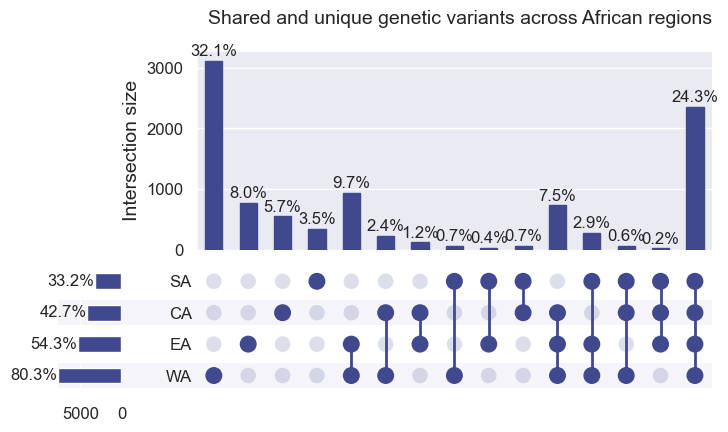

In [38]:
upsetplot.plot(
    variant_overlap_grouped,
    show_percentages=True,
    orientation="horizontal",
    facecolor="#40498E",
)
plt.title(
    "Shared and unique genetic variants across African regions",
    size=constants.BIGGER_FONT,
    pad=20,
    loc="right",
)
plt.savefig("..\Results\Figures\Shared_and_population_specific_variation.png", dpi=1200)
plt.show()

From the above plot, we observe that only 24.3% of genetic variants were shared by populations in Central, Southern, Eastern and Western Africa. This is indicative of the high genetic diversity in African populations.

Western African populations contributed the most  unique variants (32.1%) to the analysis, while Southern African populations contributed the least (3.5%). The data seems to indicate that there may be a correlation between the number of unique variants contributed by a region and the sample size of the region, since Western African populations made up the majority of the samples, and Southern African populations the least.


Calculate the degree of correlation between the number of samples comprising a regional group and the number of unique variants contributed by populations in the region. 

In [39]:
# Create a dataframe with unique variants contributed and the sample size for a region

unique_variant_regional_data = {
    "REG": ["WA", "EA", "CA", "SA"],
    "UNIQUE_VARIANT_PERCENT": [32.1, 8, 5.7, 3.5],
    "SAMPLE SIZE": [641, 109, 40, 14]
}

unique_variant_regional = pd.DataFrame(unique_variant_regional_data)

unique_variant_regional.head(5)

,REG,UNIQUE_VARIANT_PERCENT,SAMPLE SIZE
0,WA,32.1,641
1,EA,8.0,109
2,CA,5.7,40
3,SA,3.5,14


In [40]:
# Calculate the correlation 

unique_variant_regional.corr()

C:\Users\User\AppData\Local\Temp\ipykernel_21472\292599083.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  unique_variant_regional.corr()


,UNIQUE_VARIANT_PERCENT,SAMPLE SIZE
UNIQUE_VARIANT_PERCENT,1.000000,0.999448
SAMPLE SIZE,0.999448,1.000000


There is a strong positive correlation (> 0.99) between the sample size of a region and the number of unique variants contributed by that region. As the majority of samples in this analysis are from Western Africa (80%), the genetic variants under examination are skewed towards Western African populations.